In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import os

In [2]:
# Generator for CIFAR10 (32x32 RGB)
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.BatchNorm1d(256 * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 4, 4)),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),  # 32x32
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)



# Discriminator for CIFAR10
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # 16x16
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),  # 4x4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [10]:

# LightningModule
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=2e-4):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(latent_dim)
        self.discriminator = Discriminator()
        self.validation_z = torch.randn(16, latent_dim)
        self.automatic_optimization = False

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=self.hparams.lr, betas=(0.5, 0.999))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.hparams.lr, betas=(0.5, 0.999))
        return [opt_g, opt_d]

    def training_step(self, batch, batch_idx):
        real_images, _ = batch
        opt_g, opt_d = self.optimizers()
        batch_size = real_images.size(0)

        # Train Discriminator
        z = torch.randn(batch_size, self.hparams.latent_dim, device=self.device)
        fake_images = self(z).detach()

        opt_d.zero_grad()
        y_real = torch.ones((batch_size, 1), device=self.device) * 0.9
        y_fake = torch.zeros((batch_size, 1), device=self.device)

        d_real = self.discriminator(real_images)
        d_fake = self.discriminator(fake_images)

        loss_real = self.adversarial_loss(d_real, y_real)
        loss_fake = self.adversarial_loss(d_fake, y_fake)
        d_loss = 0.5 * (loss_real + loss_fake)

        self.manual_backward(d_loss)
        opt_d.step()

        # Train Generator
        opt_g.zero_grad()
        z = torch.randn(batch_size, self.hparams.latent_dim, device=self.device)
        gen_images = self(z)
        d_gen = self.discriminator(gen_images)
        g_loss = self.adversarial_loss(d_gen, torch.ones_like(d_gen))

        self.manual_backward(g_loss)
        opt_g.step()

        self.log("d_loss", d_loss, on_step=True, on_epoch=True)
        self.log("g_loss", g_loss, on_step=True, on_epoch=True)

    def on_train_epoch_end(self):
        z = self.validation_z.to(self.device)
        samples = self(z).cpu()
        samples = (samples + 1) / 2  # [-1,1] → [0,1]
    
        grid_size = int(samples.size(0) ** 0.5)
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(6, 6))
        for i in range(grid_size):
            for j in range(grid_size):
                idx = i * grid_size + j
                img = samples[idx].permute(1, 2, 0).detach().numpy()  # fix here
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
        plt.suptitle(f"Epoch {self.current_epoch}")
        plt.tight_layout()
        plt.show()

In [11]:
# CIFAR10 DataModule
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=128, num_workers=4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def prepare_data(self):
        datasets.CIFAR10(self.data_dir, train=True, download=True)
        datasets.CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            full = datasets.CIFAR10(self.data_dir, train=True, transform=self.transform)
            self.train_ds = full
        if stage == "test" or stage is None:
            self.test_ds = datasets.CIFAR10(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.num_workers)

Seed set to 42
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 1.1 M  | train
1 | discriminator | Discriminator | 663 K  | train
--------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.979     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

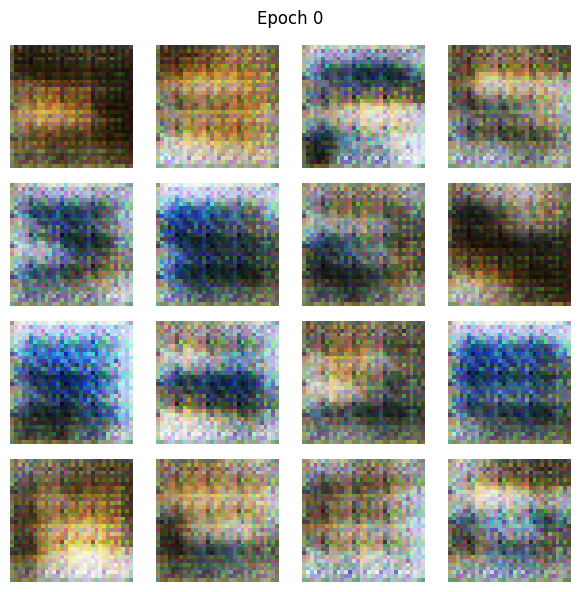

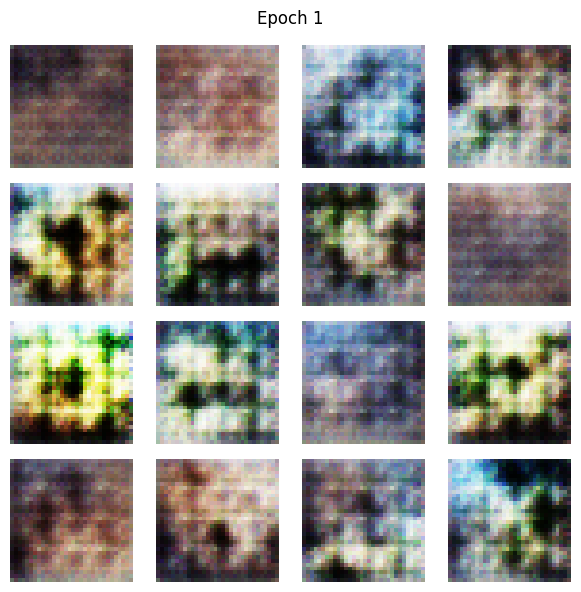

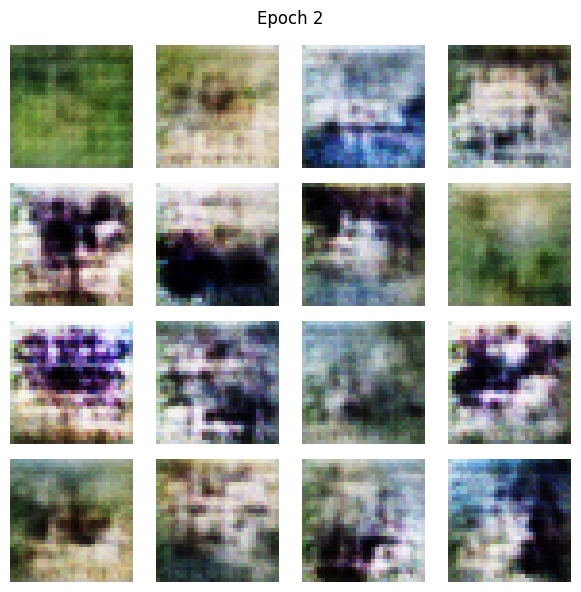

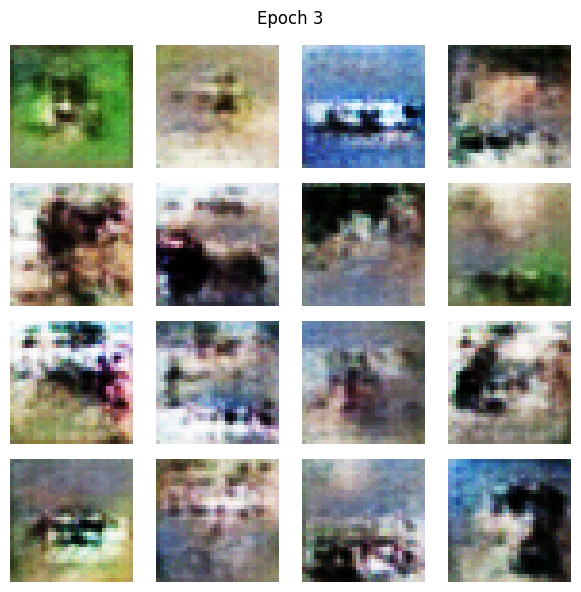

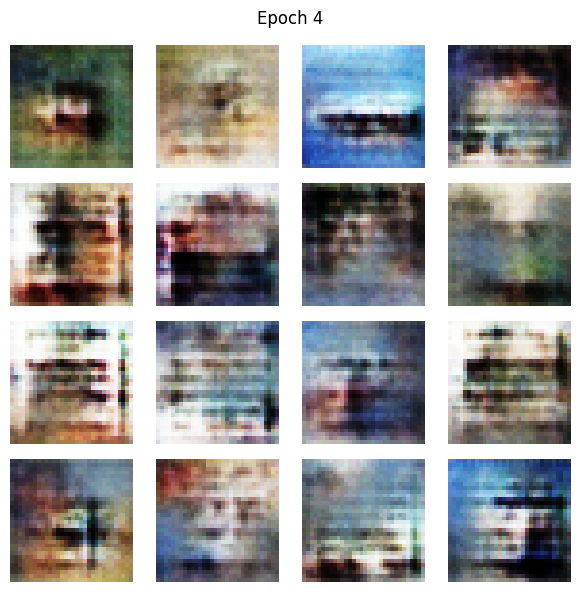

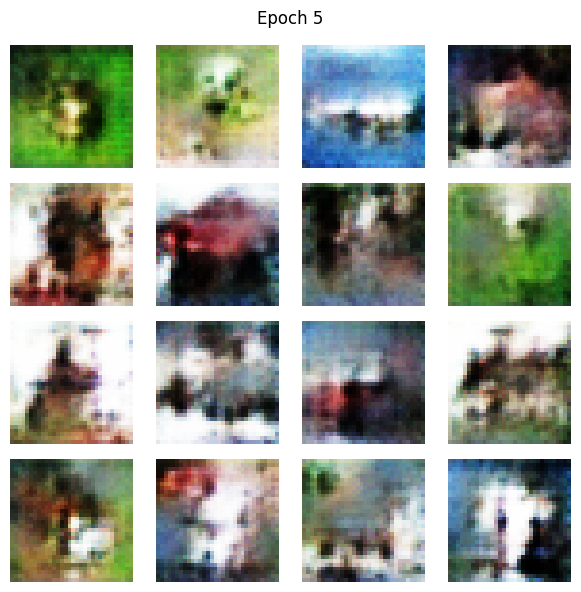

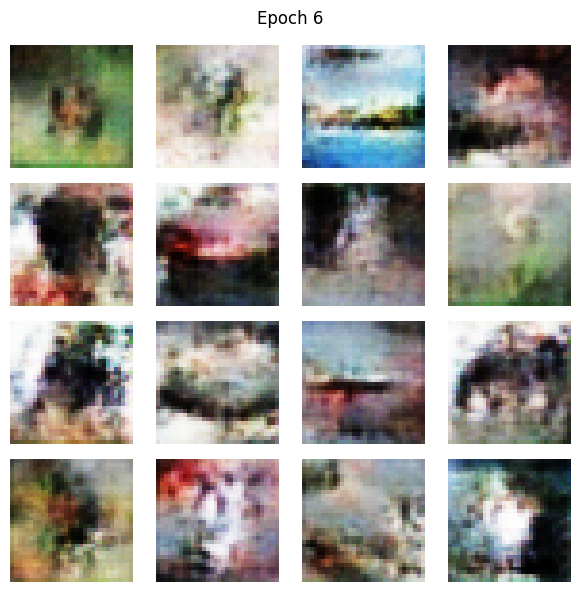

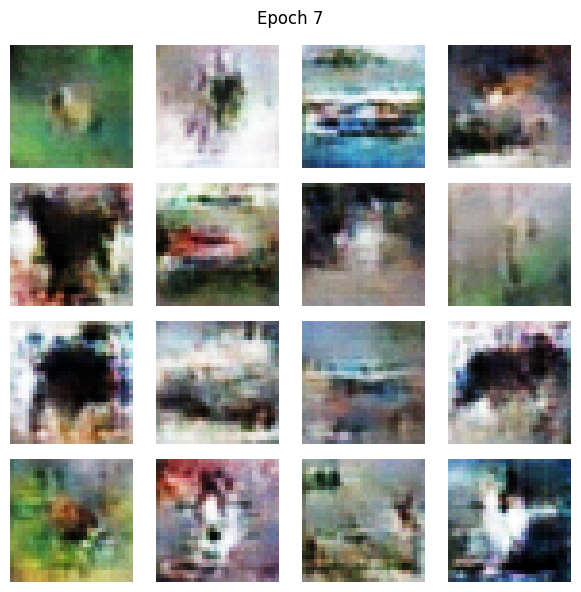

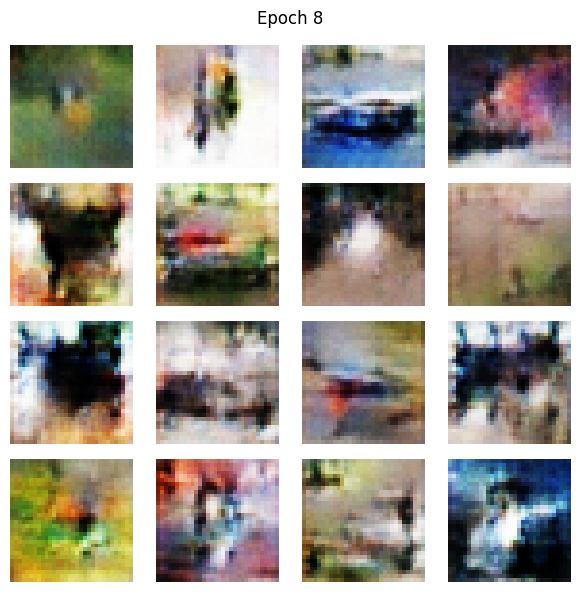

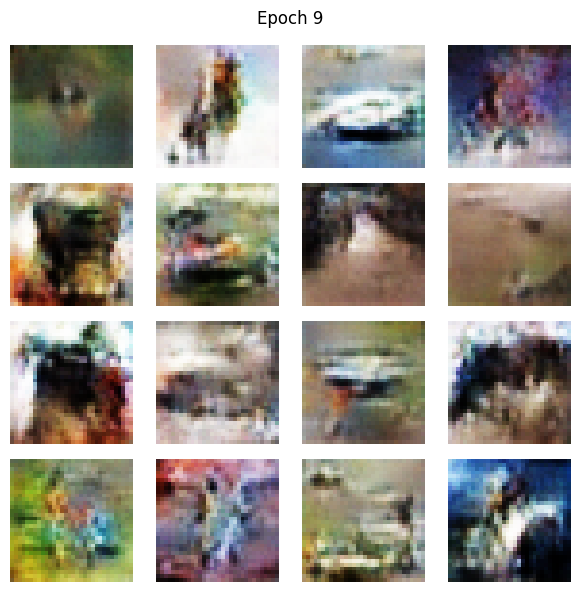

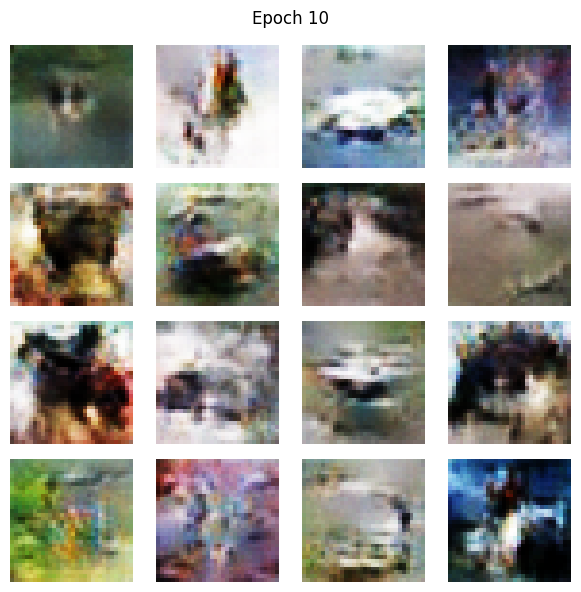

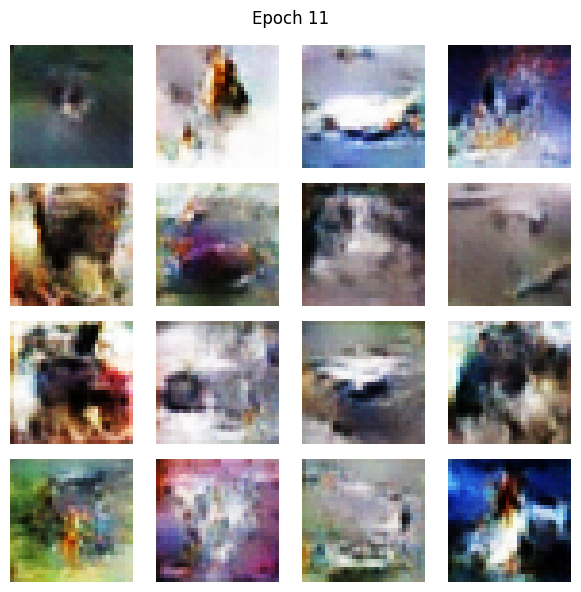

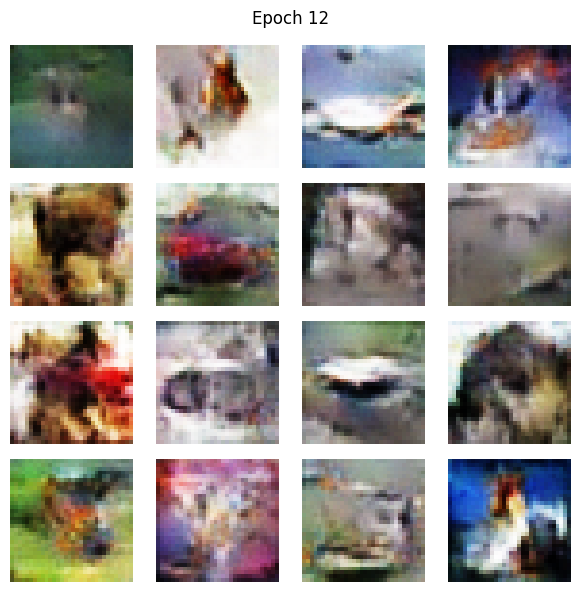

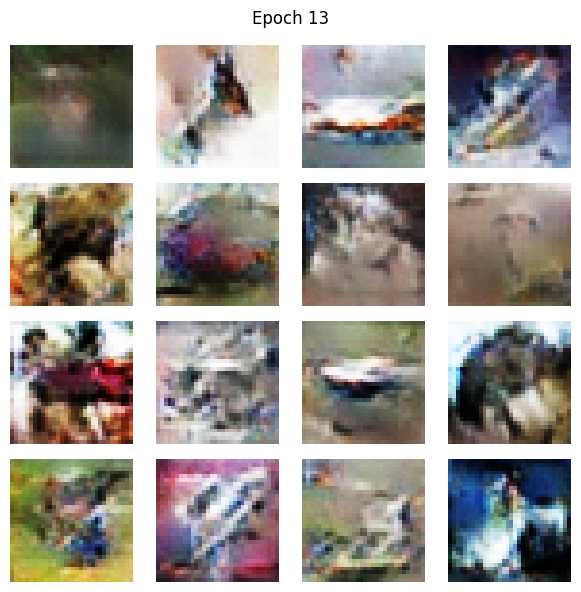

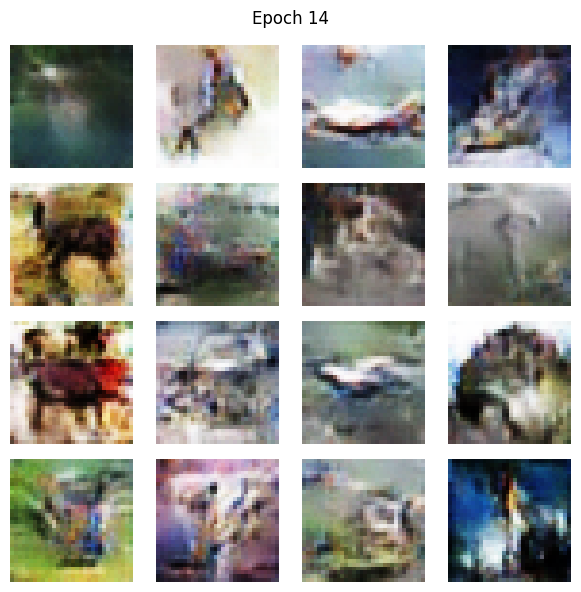

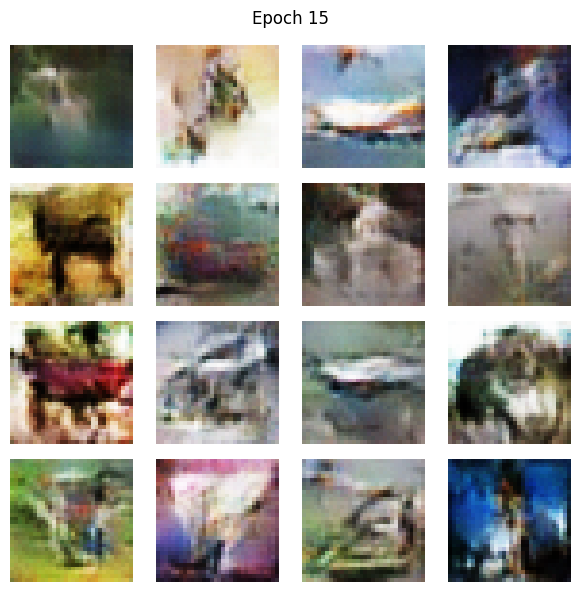

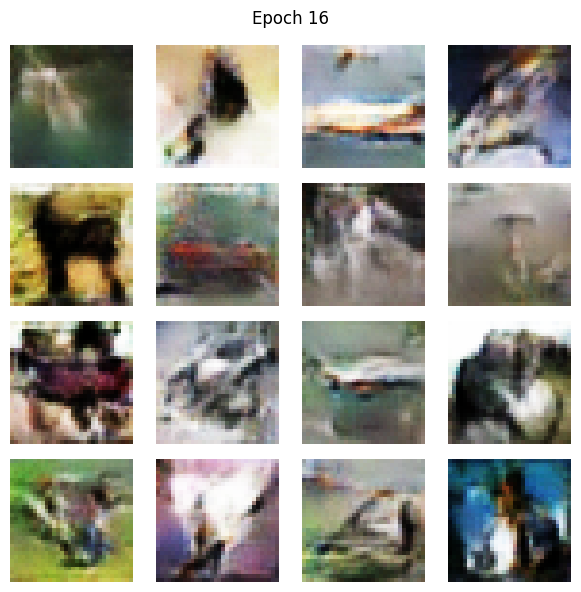

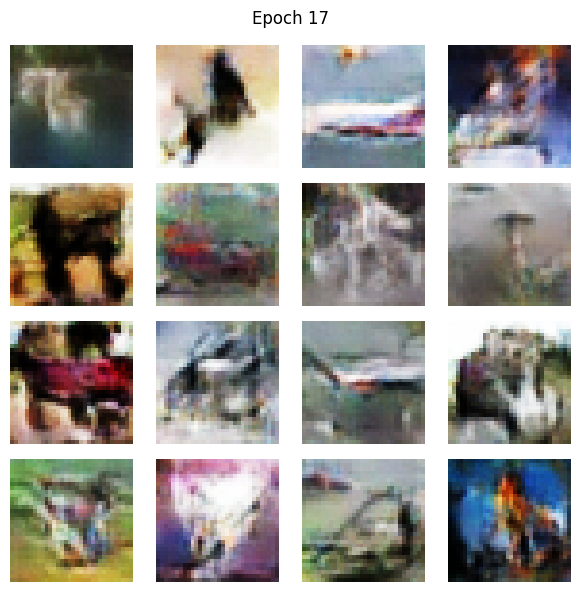

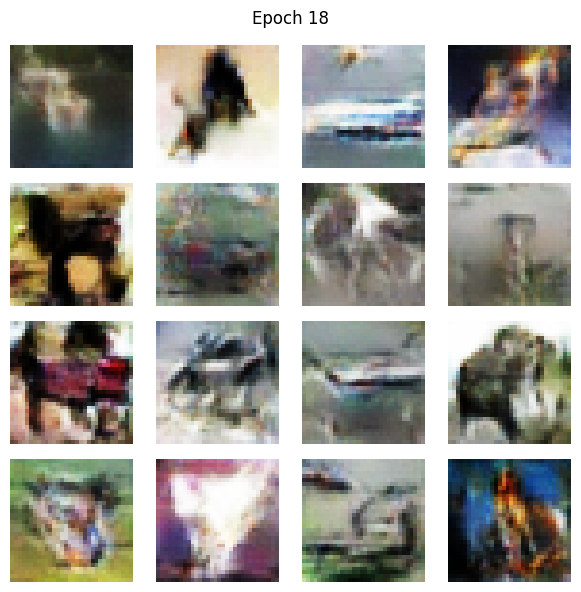

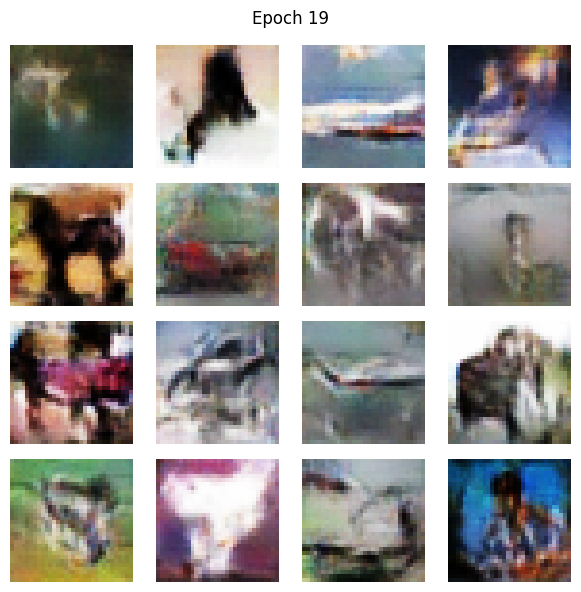

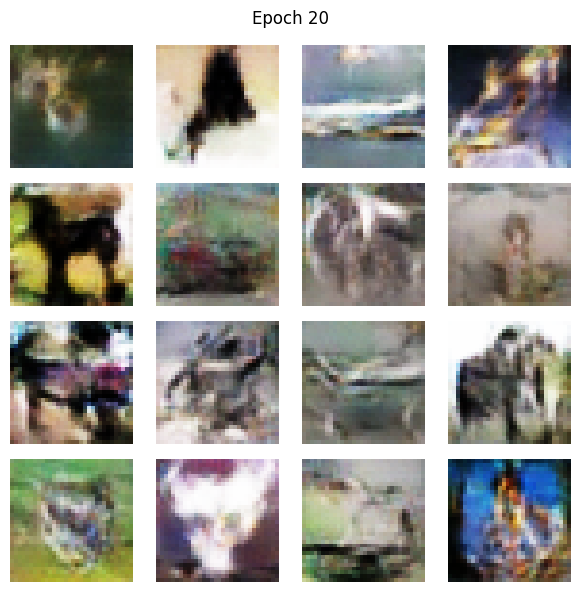

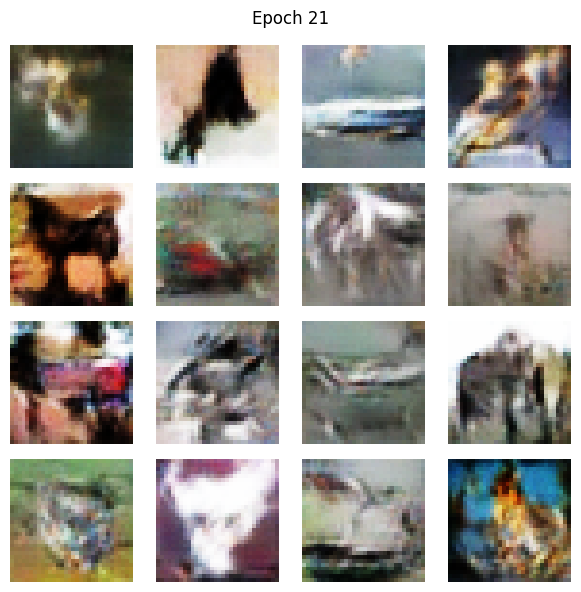

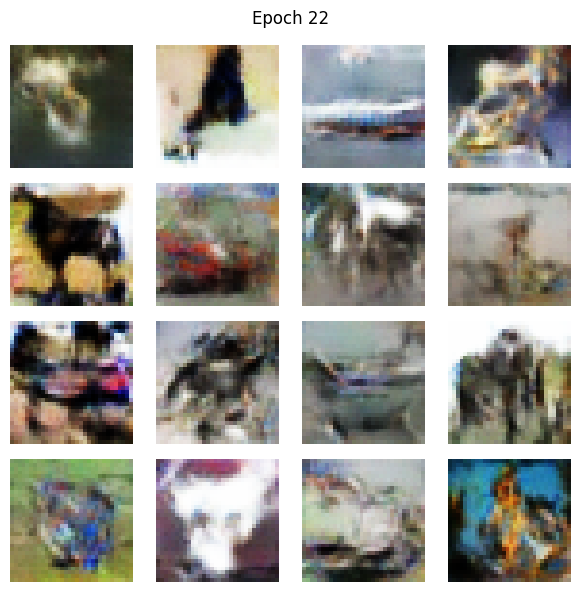

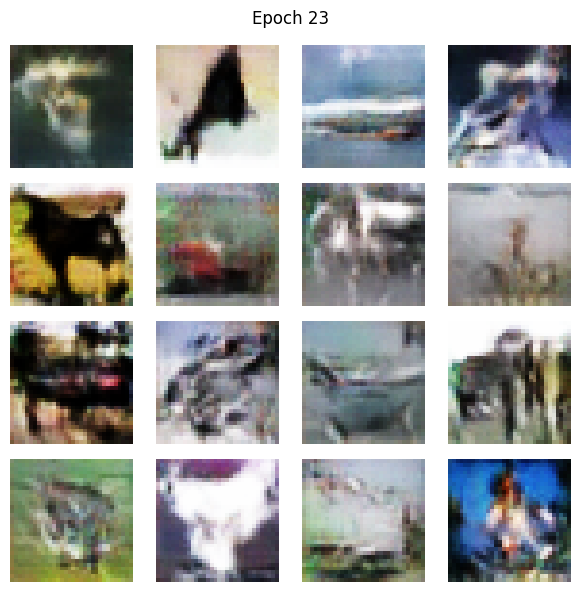

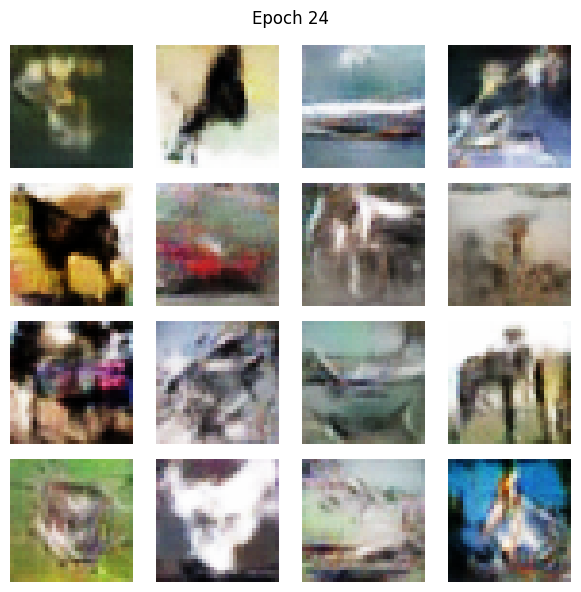

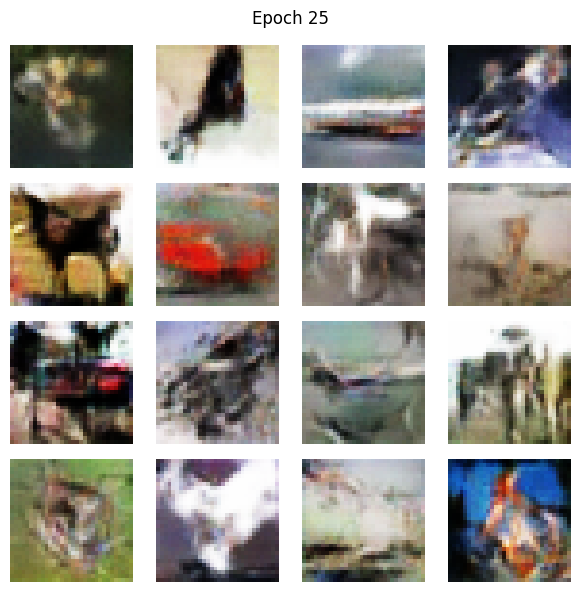

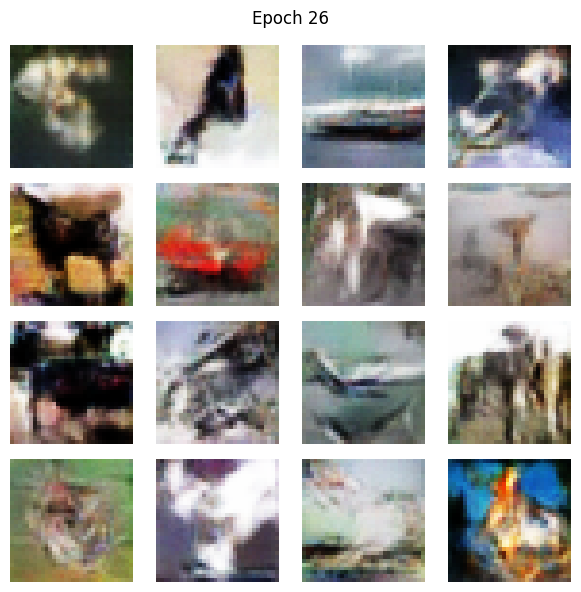

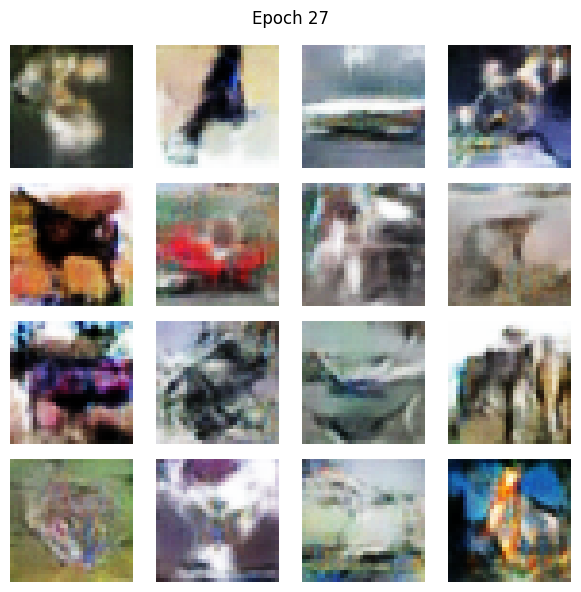

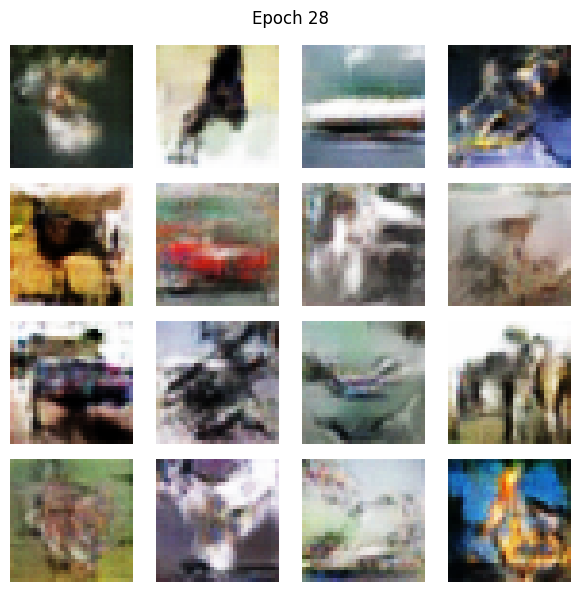

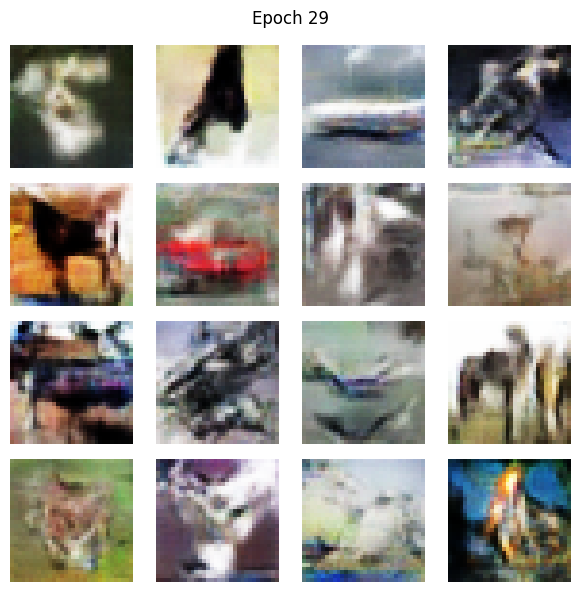

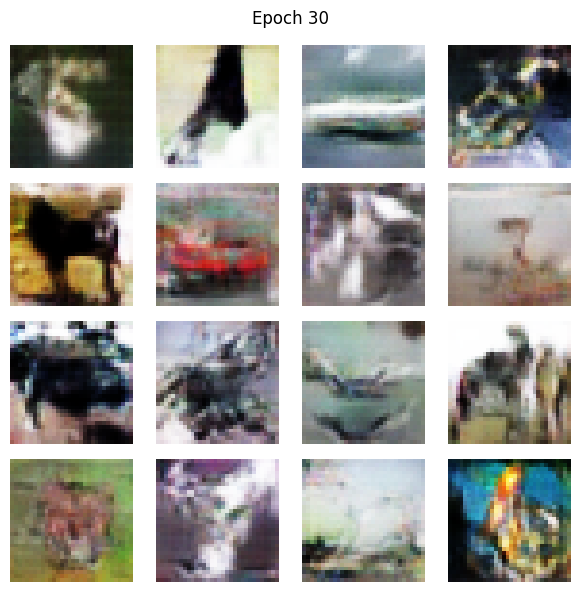

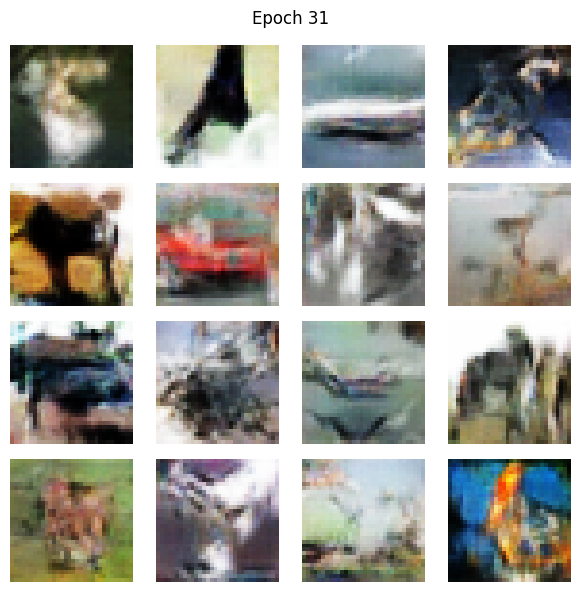

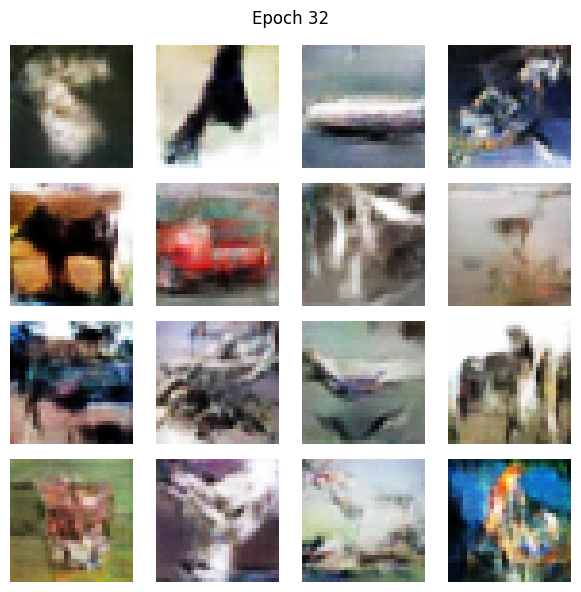

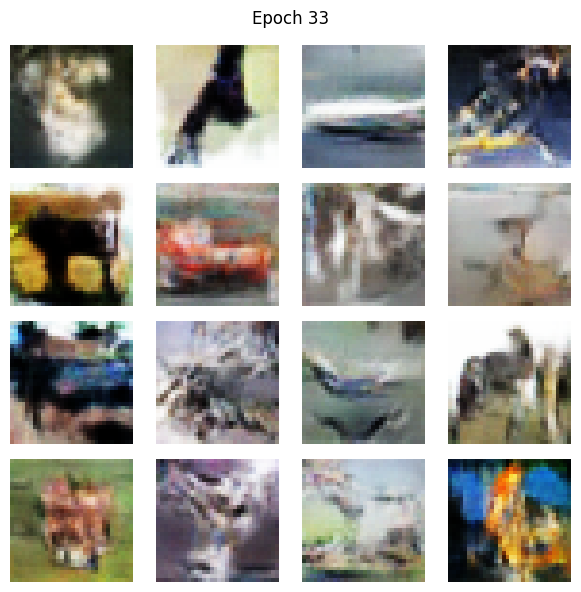

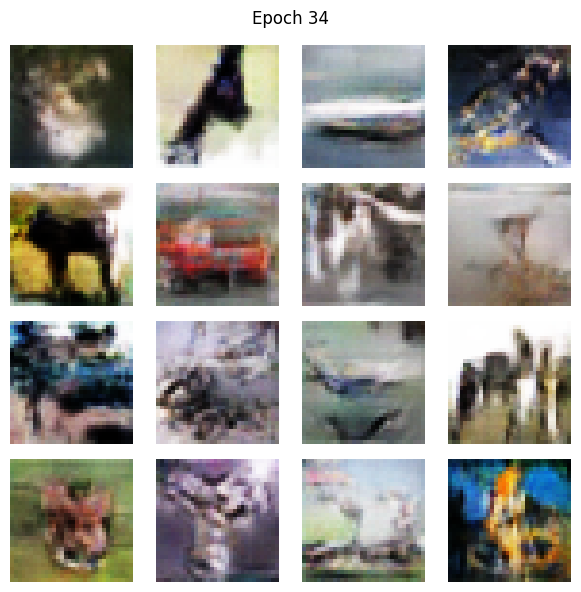

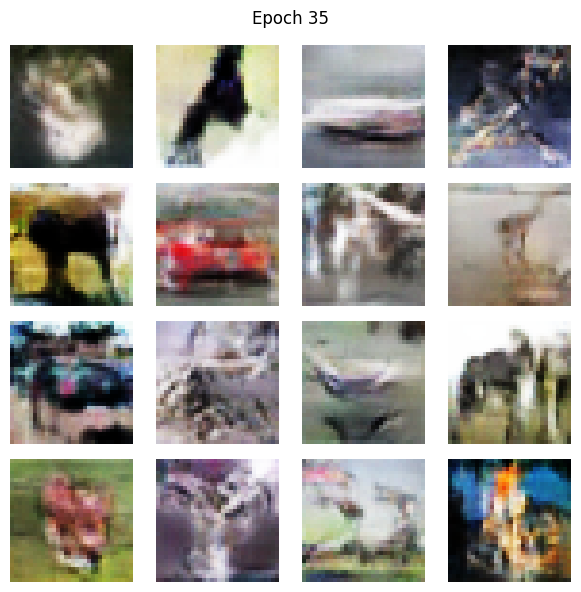

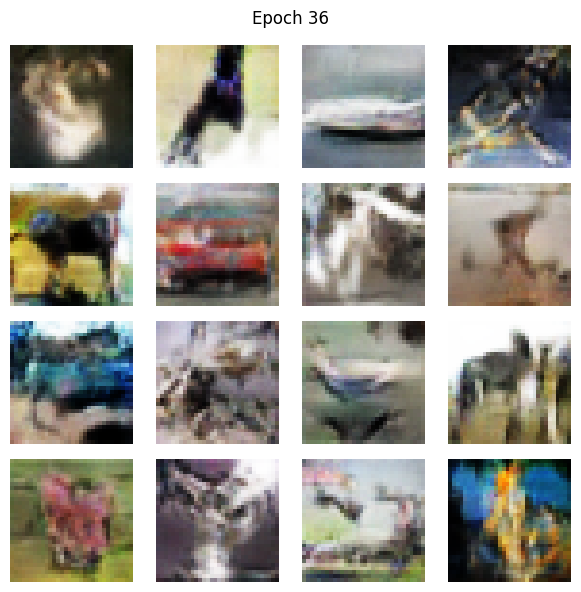

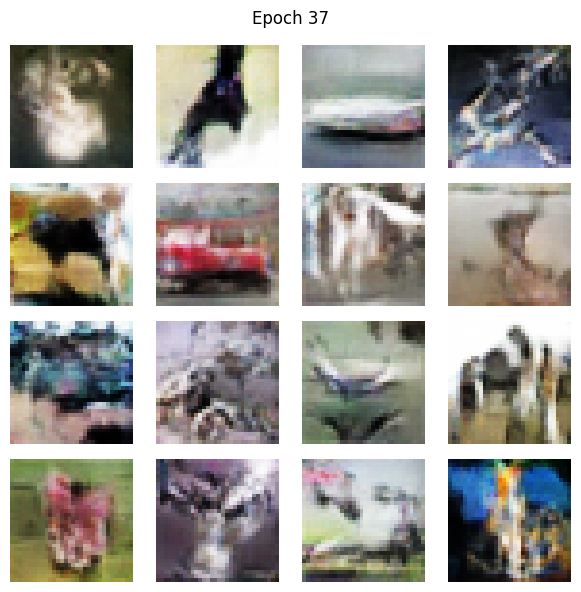

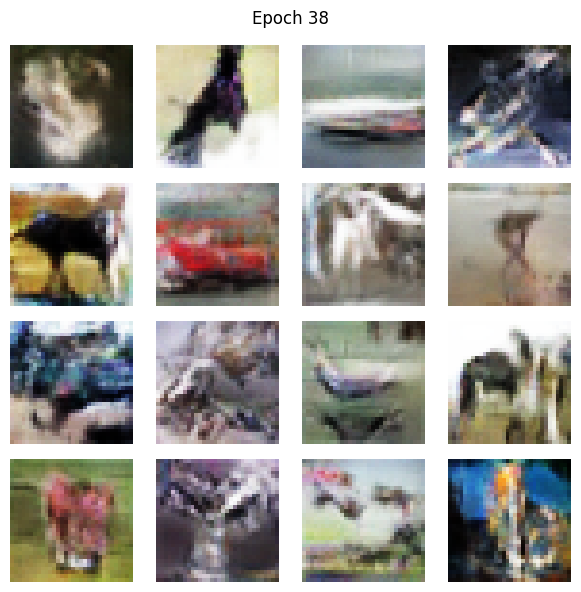

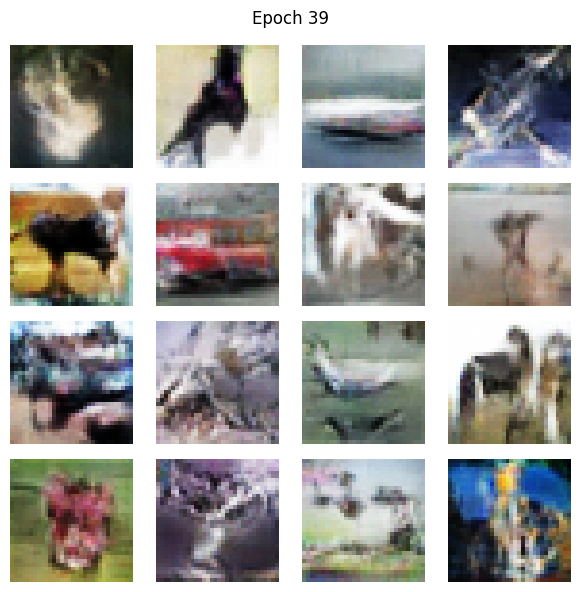

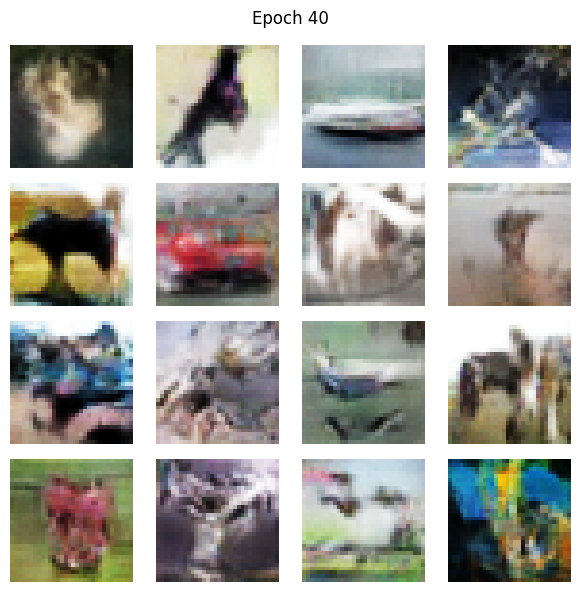

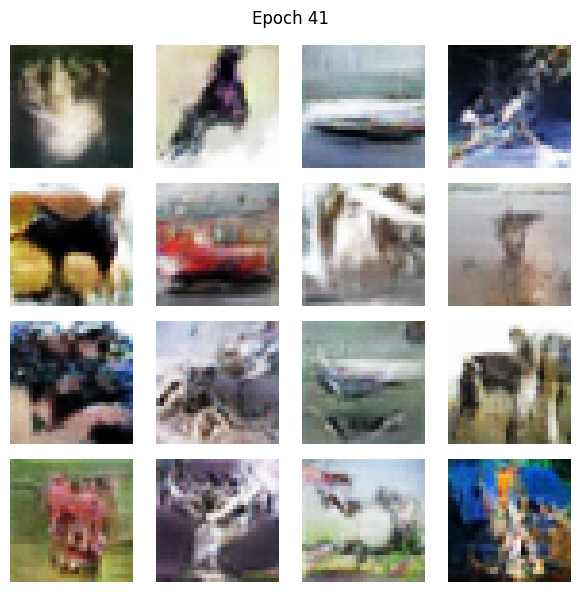

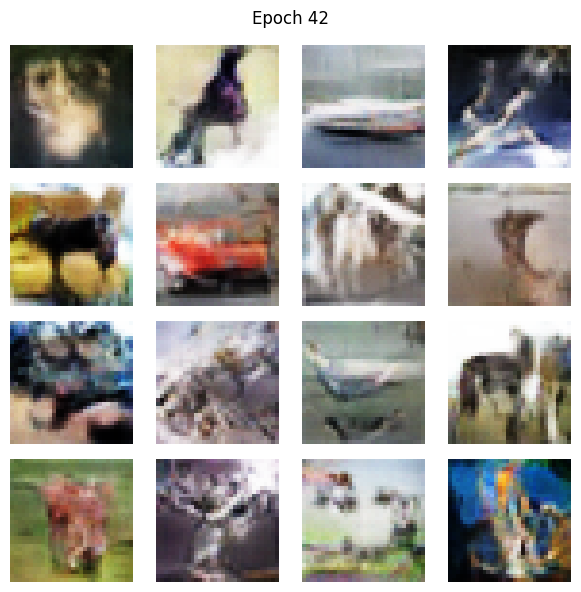

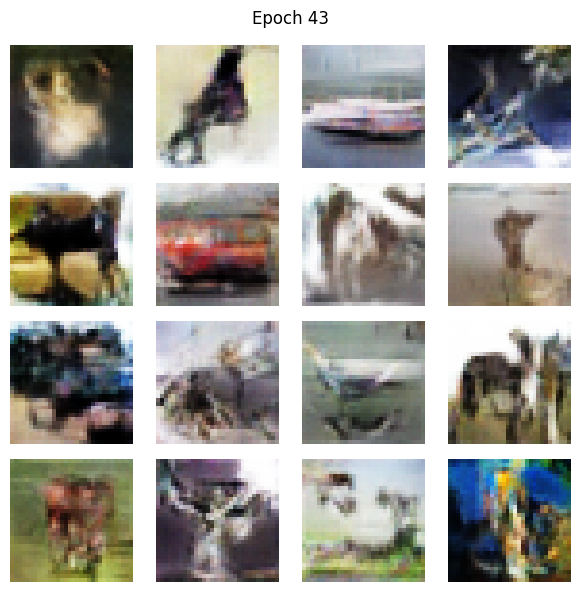

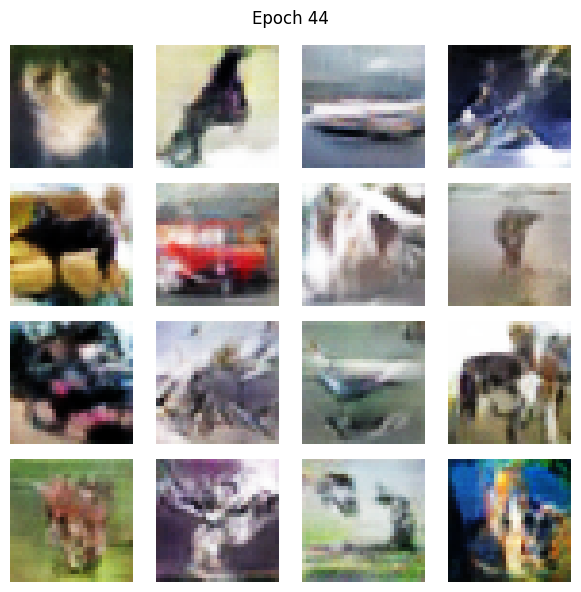

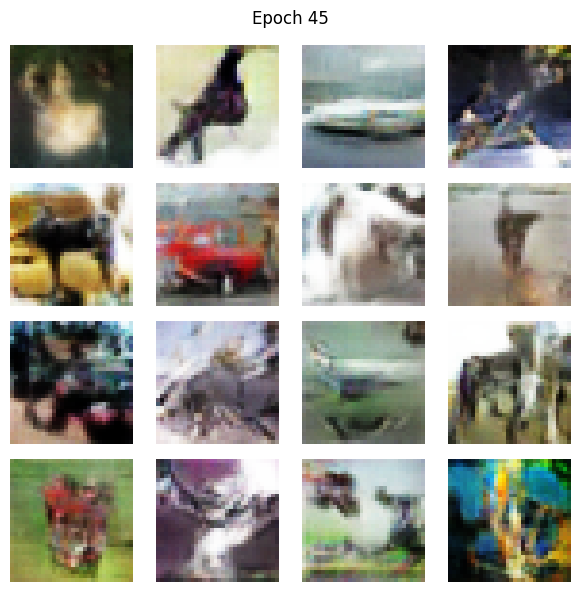

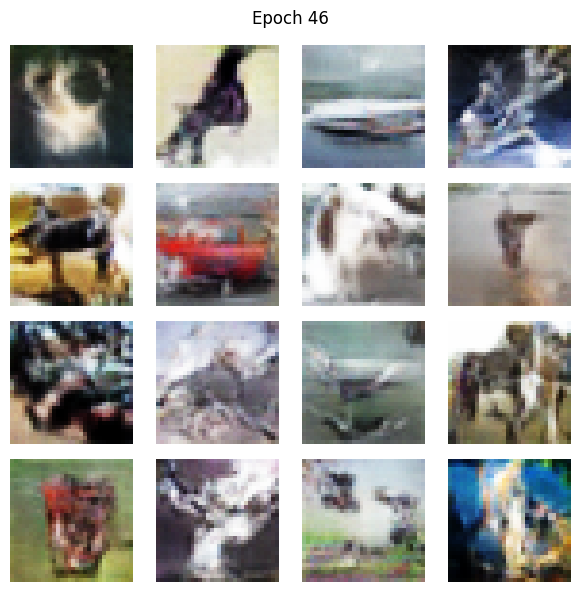

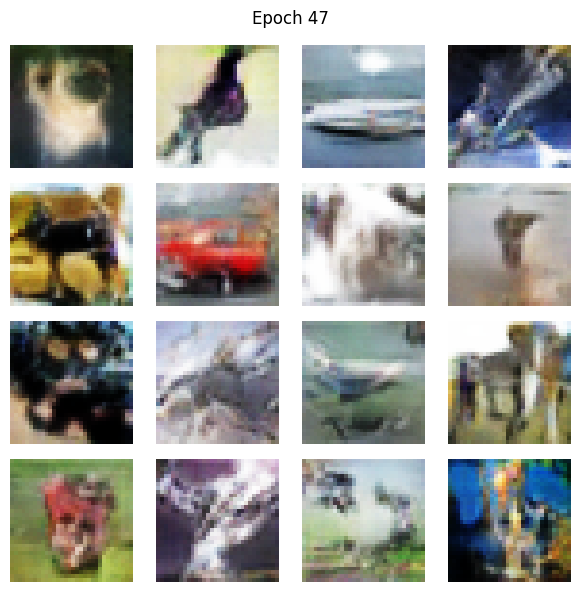

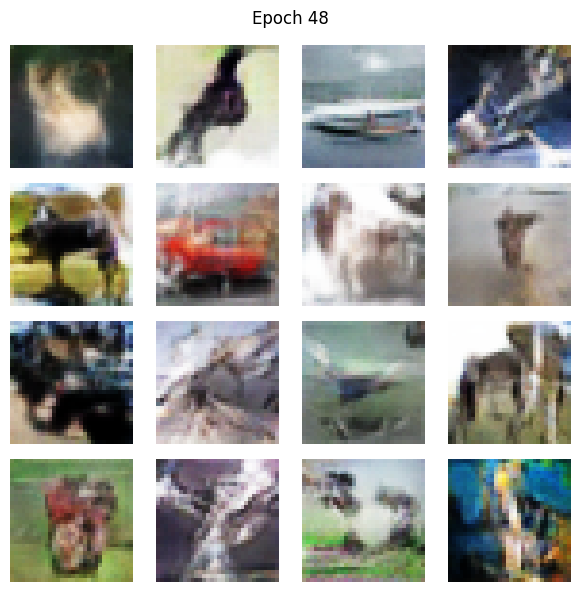

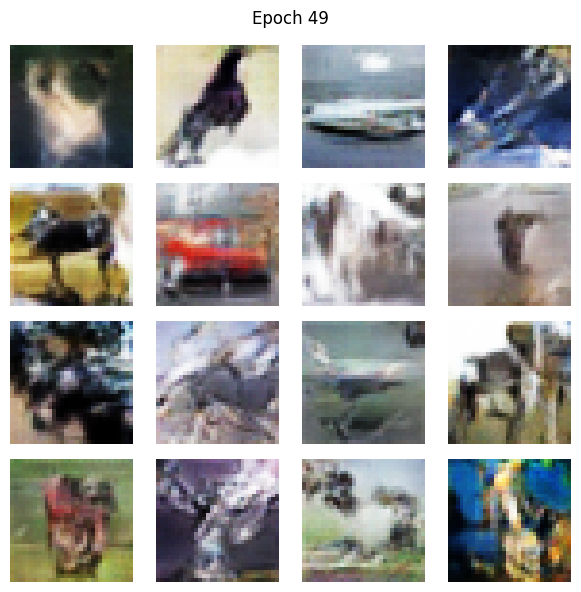

`Trainer.fit` stopped: `max_epochs=50` reached.


In [12]:
# Training entry point
torch.set_float32_matmul_precision('medium')
if __name__ == "__main__":
    pl.seed_everything(42)
    data_module = CIFAR10DataModule()
    model = GAN(latent_dim=100, lr=2e-4)
    trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=50,
        default_root_dir="./dcgan_cifar10"
    )
    trainer.fit(model, data_module)